# Partikelfilter

Diese Übung baut auf der Übung 1 auf und nutzt daher die Implementierungen des Balistik-Beispiels aus der Vorlesung.

## 1. Vorbereiten unserer Simulationsumgebung
Zunächst definieren wir wieder die Konstanten unseres Systems:

In [1]:
# model preferences
time <- 100    # time [s]
tstep <- 10    # steps / sec [1/s]
times <- time*tstep

# physical constants
g    <- -9.81   # gravitational accelaration [m/(s^2)]
sd.v <- 10      # accuracy of liftoff speed [m/s]
sd.a <- 1       # accuracy of elevation angle in [deg]
turb.x <- 10       # acceleration by turbulences [m/(s^2)]
turb.y <- 10       # acceleration by turbulences [m/(s^2)]
cw   <- 0.0001 # aerobraking factor
sd.o <- 10000     # observation accuracy [m]

# game preferences
xmax <- 21000
epsilon <- 300

# plot preferences
ymin <- -100

deg2rad <- function(x) x / 180 * pi

Hier noch die Funktion die uns den Start-/Initialzustand unseres Systems berechnet.    
Zur Erinnerung: Unsere Zustände entsprechen einem Vektor der Länge 4 mit x-, y-Koordinate und der Geschwindigkeit in x- und y-Richtung.

In [2]:
init <- function(ang = 45, v0 = 500, location = 0) {
    v <- v0 + rnorm(1, sd=sd.v)
    a <- deg2rad(rnorm(1, mean=ang, sd=sd.a))
    c(location, 0, v * cos(a), v * sin(a))
}

Mit der Transitionsfunktion berechnen wir dann ausgehend von einem Zustand in Zeitschritt t einen neuen Zustand in Zeitschritt t+1. Mithilfe dieser Funktion können wir also den Folgezustand unseres Projektils berechnen!

In [3]:
trans <- function(s) {
    dt <- 1/tstep
    eps.x <- rnorm(1, mean=0, sd=turb.x)
    eps.y <- rnorm(1, mean=0, sd=turb.y)
    acc.x <- -sign(s[3]) * cw * s[3]^2 + eps.x
    acc.y <- g - sign(s[4]) * cw * s[4]^2 + eps.y
    s.x <- s[1] + s[3] * dt + 0.5 * acc.x * dt * dt
    s.y <- s[2] + s[4] * dt + 0.5 * acc.y * dt * dt
    v.x <- s[3] + acc.x * dt
    v.y <- s[4] + acc.y * dt
    c(s.x, s.y, v.x, v.y)
}

Die Shoot-Funktion simuliert dann mithilfe der Transitionsfunktion die komplette Flugbahn unseres Projektils!

In [4]:
shoot <- function(angle, velocity, location) {
    target <- array(0, dim=c(times,4))
    target[1,] <- init(angle, velocity, location)
    for (t in 2:times) {
        target[t,] <- trans(target[t-1,])
        if (target[t,2] < 0) {
            target <- target[1:(t-1),]
            break
        }
    }
    
    target
}

Mithilfe der Plotshot-Funktion können wir die Flugbahn des Projektils dann visualisieren!

In [5]:
plotshot <- function(target=array(0, dim=c(1,4)), playerLocations=NULL, title="Target", new.plot=TRUE) {
    if (new.plot) {
        plot(NA, ylim=c(ymin,12000), xlim=c(0, xmax), ylab="Height [km]", xlab="Distance [km]", axes=FALSE)
    }
    lines(target[,1], target[,2], col="red", lwd=2)
    axis(2, labels=c("0","2.5","5","7.5","10"), at=c(0,2500,5000,7500,10000))
    axis(1, labels=c("0","5","10","15","20"), at=c(0,5000,10000,15000,20000))
    
    # plot the y=0 line which represents the "ground"
    abline(h=0, col="lightgray", lwd=2)
    
    # tanks
    for (player in seq_along(playerLocations)) {
        points(playerLocations[player], 0, pch=12, cex=1.4, col="brown")
        text(playerLocations[player] + 200, 100, paste0("Player ", player), adj=c(0,0))
    }

    invisible(NULL)
}

## 2. Erweitern unserer Umgebung
Da wir in dieser Übung nun nicht nur die Flugbahn des Projektils simulieren wollen, müssen wir unser Szenario erweitern!   
Es wird angenommen, dass wir den Zustand des Projektils nur näherungsweise berechnen können, indem wir dazu Signale nutzen die von einer (fiktiven) Radarstation am Boden empfangen werden. Daher definieren wir nun erstmal ein paar Größen bzgl. des Radars!

In [6]:
# x- und y-Koordinaten des Radars
radar.x <- 5000
radar.y <- 0
radar <- c(radar.x, radar.y)
# Messungenauigkeiten 
radar.sd.rad <- 0.1
radar.sd.ang <- 5

Im Skript wird ein Observationsmodell, basierend auf Winkel- und Distanzmessungen einer fiktiven Radarstation, beschrieben. Nachfolgend finden Sie die Implementierung dieser Funktion `robserve(s)`, die gegeben die Position des Projektils zu einem Zeitpunkt eine mögliche Beobachtung $y$ sampled. Mit dieser Funktion simulieren/generieren wir also die empfangenen Signale unserer (fiktiven) Radarstation! 

In [7]:
robserve <- function(s) {
    s.dx <- s[1] - radar.x
    s.dy <- s[2] - radar.y
    rad <- sqrt(s.dx^2 + s.dy^2)
    ang <- atan2(s.dy, s.dx) / pi * 180
    obsrad <- rnorm(1, mean=rad, sd=rad * radar.sd.rad)
    obsang <- rnorm(1, mean=ang, sd=radar.sd.ang) / 180 * pi
    #we output not the angle and distance, but x-y coordinates
    c(obsrad * cos(obsang) + radar.x,
      obsrad * sin(obsang) + radar.y)
}

## 3. Vorbereitungen für den Partikelfilter
Wie wir uns aus den vergangenen Übungen erinnern, bestehen unsere Modelle aus verschiedenen Komponenten:
* Transitions-/Systemmodell
* Beobachtungsmodell
* Initialzustand

Den Initialzustand und das Transitionsmodell haben wir schon gegegben/definiert. Damit fehlt noch das  Beobachtungsmodell $p(y | s)$:   
Dieses gibt die Wahrscheinlichkeitsdichte an, mit der eine Beobachtung von einem Zustand erzeugt wird. Nachfolgend finden Sie die Implementierung der Funktion `update(s, obs)`, die gegeben einen Zustand `s` und einer Beobachtung `obs die *Wahrscheinlichkeitsdichte* dieser Beobachtung im gegebenen Zustand berechnet (im Gegensatz zur Funktion `robserve(s)`, die eine Beobachtung *sampled*). 

In [8]:
update <- function(s, obs) {
    #strategy: compute the true angle and distance from s
    #and the observed angle and distance from obs
    #then compute the density of a normal with mean=truth
  
    o.dx <- obs[1] - radar.x
    o.dy <- obs[2] - radar.y
    obsrad <- sqrt(o.dx^2 + o.dy^2)
    obsang <- atan2(o.dy, o.dx) / pi * 180
    if (obsang < 0)
        # ensure the range is [0, 360), not (-180, 180]
        obsang <- 360 + obsang
    
    s.dx <- s[1] - radar.x
    s.dy <- s[2] - radar.y
    rad <- sqrt(s.dx^2 + s.dy^2)
    ang <- atan2(s.dy, s.dx) / pi * 180
    if (ang < 0)
        # ensure the range is [0, 360), not (-180, 180]
        ang <- 360 + ang
    
    # angles are now in range [0, 360)
    # that means, e.g., 1° and 359° (= -1°) are considered far apart
    # if both angles are < 90 / > 270 (i.e. at the right side of the unit circle),
    # then make large angles negative (e.g. 359 → -1)
    if ((obsang < 90 || obsang > 270) && (ang < 90 || ang > 270)) {
        mn <- function(a) if (a > 270) a - 360 else a
        obsang <- mn(obsang)
        ang <- mn(ang)
    }
    
    dnorm(obsrad, mean=rad, sd=rad * radar.sd.rad) * dnorm(obsang, mean=ang, sd=radar.sd.ang)
}

In einem Partikelfilter wird die a-posteriori Wahrscheinlichkeitsdichte durch die Verteilung von Samples/Partikeln im Zustandsraum repräsentiert. Nachfolgend finden Sie dazu eine Funktion `makesamples(n, angle, velocity, location)`, welche $n$ zufällige Trajektorien sampled.

In [9]:
makesamples <- function(n=50, angle, velocity, location) {
    replicate(n, shoot(angle, velocity, location))
}

Zu guter Letzt werden hier nochmal zwei Funktionen gegeben, mit denen man unser erweitertes Szenario mit der zusätzlichen Radarstation einmal visulasieren kann!

In [10]:
plotshot2 <- function(target=array(0, dim=c(1, 4)), observation=NULL, samples=NULL, ostep=10, title="Target") {
    plot(NA, ylim=c(ymin,12000), xlim=c(0, xmax), ylab="Height [km]", xlab="Distance [km]", axes=FALSE)
    
    # plotting sample trajectories
    if (!is.null(samples)) {
        n <- length(samples)
        for(i in 1:n)
            lines(samples[[i]][,1],samples[[i]][,2],col="gray")
    }
    
    # plotting (simulated) observations
    if (!is.null(observation)) { #if not empty run
        osteps <- seq(from=ostep, to=nrow(target), by=ostep)
        lines(observation[1,osteps], observation[2,osteps], col="green")
    }
  
    #position of radar station
    points(radar.x,radar.y,pch=12, cex=1.4, col="brown")

    # plotting real trajectory
    plotshot(target, NULL, title, new.plot=FALSE)
    
    invisible(NULL)
}

main2 <- function(){
  #simply plot multiple samples
  ss <- makesamples(50,60,800,0)
  #observe a single trajectory
  observation <- apply(ss[[1]],1,function(sr) robserve(sr))
  #plot this
  plotshot2(ss[[1]],samples=ss,observation=observation)
}

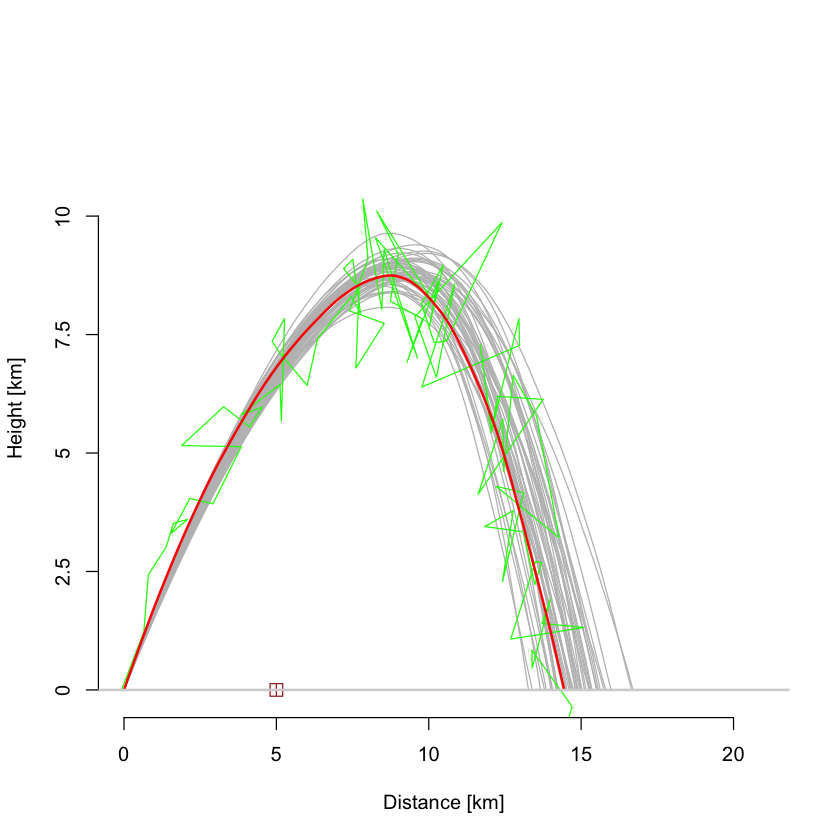

In [11]:
main2()

## 4. Implementierung des Partikelfilters
Nun haben wir alle notwendigen Vorbereitungen getroffen, um unseren Partikelfilter zu implementieren. Bevor wir jedoch damit beginnen, hier eine kurze Visualisierung des Partikelfilters: [https://www.youtube.com/watch?v=5nswUcByXLo](https://www.youtube.com/watch?v=5nswUcByXLo)   
Die generelle Idee die hinter diesem Algorithmus steckt, ist, dass wir zunächst beliebig viele Partikel aus einer Gleichverteilung sampeln. Nachdem wir eine Beobachtung empfangen, können wir nun die Partikel löschen, welche gegeben unserer Beobachtung eine geringe Wahrscheinlichkeitsdichte aufweisen.   
Fragen an Euch:    
1. Was repräsentieren die Partikel in unserem Balistikbeispiel?   
2. Mithilfe welcher Funktion können wir die Wahrscheinlichkeitsdichte unserer Partikel gegeben eine Beobachtung berechnen?   



Da wir nun eine generelle Idee davon entwickeln konnten, wie der Partikelfilter arbeitet können wir uns an die Implementieren wagen. Damit ihr nicht in der Komplexität des Algorithmus erstickt, gebe ich euch zunächst noch die Implementierung der Resampling-Funktion vor, welche uns neue Partikel, gegeben alten Partikeln und ihrer Wahrscheinlichkeitsdichte, berechnet.

In [12]:
resample <- function(samples, weights){
  c_1 <- weights[1]
  i <- 1
  N <- length(weights)
  c <- 1:N
  u <- 1:N
  c[1] <- c_1
  x_ <- samples
  w_ <- weights
  u_1 <- runif(1, 0, 1/N)
  
  for (j in 1:N) {
    u[j] <- u_1 + (1/N * (j - 1))
    while (u[j] > c[i]){
      i <- i + 1
      c[i] <- c[i-1] + weights[i]
    }
    x_[,j] <- samples[,i]
    w_[j] <- 1/N
  }
  #browser()
  return(x_)
}


1. Schreiben Sie nun eine Funktion `filter(n, observation, ostep, ...)` welche Bayessches Filtern mittels eines Partikelfilters implementiert (Algorithmus siehe Skript S. 101). Der Parameter `n` stellt die Anzahl der Partikel dar. Die Beobachtungsdaten (generiert von der Radarstation) werden mit dem Parameter observations übergeben, `ostep` bestimmt die Frequenz der Beobachtungen. Weitere Parameter bestimmen den angenommene initialen Winkel, Geschwindigkeit und Position. In der Funktion sollen zunächst die Partikel initialisiert werden. Nutzen Sie die Funktion `update(s, obs)` um Gewichte für die initialen Partikel zu berechnen. Iterieren Sie anschließend schrittweise über alle Zeitpunkte, indem Sie für jeden Partikel mittels `trans(s)` zunächst die Prediction und, alle `ostep` Zeitschritte, mittels `update(s, obs)` den Updateschritt durchführen, bei dem die Partikel neu gewichtet werden. Berechnen sie dabei auch auf Basis der neuen Gewichte die neuen Partikel, indem sie die Resampling-Methode verwenden!

In [16]:
filter <- function(n, angle, velocity, location, observation, ostep, do.resample = TRUE) {
    times = nrow(observation) # number of observations
    state <- array(0, dim=c(times, 4, n)) # 3D array for saving the computet states (=particles) for every timestep. dim=times x 4(one state = 4 dim vector) x number of particles
    weights <- array(0, dim=c(times, n)) # 2D array to save the weight of each particle in each time step
    
    # todo: create initial states and weights for n particles
    state[1,,] <- 'Implement me!'
    weights[1,] <- 'Implement me!'
    weights[1,] <- 'Implement me!'
    
    # forward run
    for (t in 2:times) {
        # todo: compute the predict step
        state[t,,] <- 'Implement me!'
        
        if(t %% ostep == 0) {
            # todo: compute the update step
            weights[t,] <- 'Implement me!'
            if (sum(weights[t,]) == 0)
                break()
            # todo: normalize weights
            weights[t,] <- 'Implement me!'
            
            # do the resampling
            if (do.resample) {
                resample.result <- 'Implement me!'
                state[t,,] <- 'Implement me!'
                weights[t,] <- 'Implement me!' 
            }
        } else {
            # no observations, weights do not change
            weights[t,] <- weights[t-1,]                      
        }
    }
    invisible(list(forward=state,weights=weights))
}

2. Testen Sie ihren Partikelfilter, indem sie eine Funktion `runfilter(n, ...)` schreiben. In der Funktion soll zunächst die Trajektorie eines Projektils simuliert und mittels `robserve` die dazugehörigen Observations gesampled werden.

In [17]:
plotfilter <- function(state, weights, observation, target, ostep=10, title="Forward") {
    n <- dim(state)[3]
    times <- dim(state)[1]

    xosteps <- seq(from=50, to=times, by=50)
    osteps <- seq(from=ostep, to=times, by=ostep)

    plot(state[1,,1], state[2,,1], type="l",
         ylim=c(ymin, 12000), xlim=c(0, xmax), ylab="Height [km]", axes=FALSE)

    axis(2, labels=c("0","2.5","5","7.5","10"), at=c(0,2500,5000,7500,10000))
    abline(h=0,col="lightgray",lwd=2)

    mtext(title, 2, line=3.5)

    # plot the particles' trajectories
    for(i in 1:n)
        lines(state[,1,i],state[,2,i],col="gray")

    lines(observation[osteps,1], observation[osteps,2], col="green", type="b")
    
    mn <- cbind(apply(state[,1,] * weights, 1, sum), apply(state[,2,] * weights, 1, sum))
    lines(mn,col="blue",lwd=2)
    
    lines(target[,1],target[,2],col="red",lwd=2,lty="dotted")
    
    points(radar.x, radar.y, pch=12, cex=1.4, col="brown")
    text(radar.x+200, radar.y+100, "Radar", adj=c(0,0))
    
    legend("topleft",bty="n",
        lty=c(1,3,1,1,1),
        lwd=c(2,2,2,2,1),
        col=c("gray", "red", "green", "blue", "blue"),
        legend=c("Simulation", "Target", "Observations", "Posterior Mean", "95%"))
}

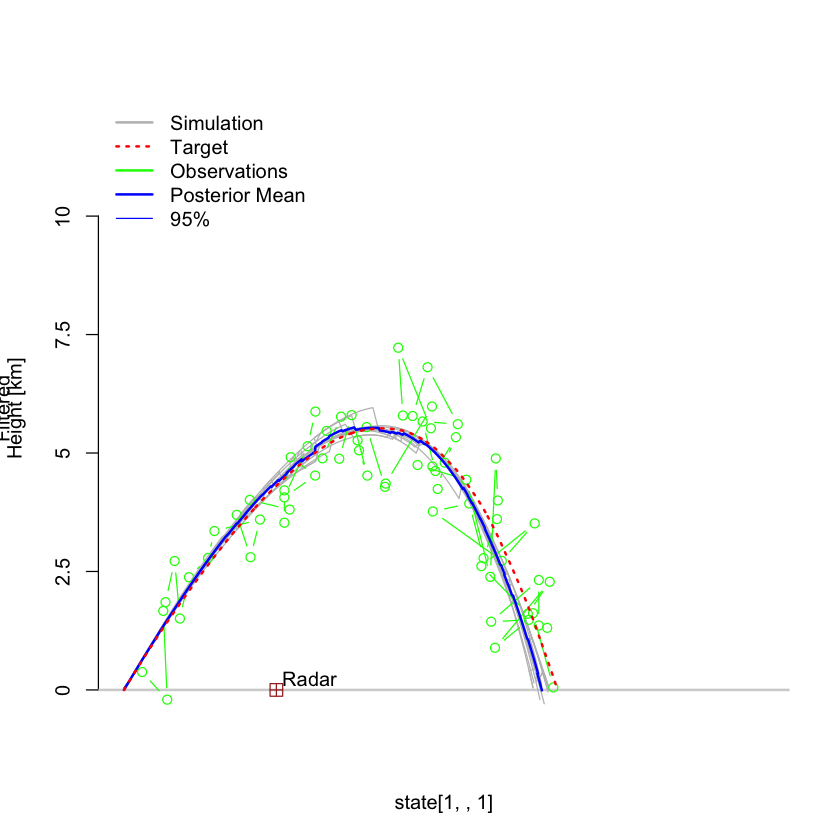

In [18]:
runfilter <- function(n = 250, angle = 47, velocity = 600, location = 0, ...) {
    # simulate target
    target <- 'Implement me!'

    # calculate observations
    observation <- array(0, dim=c(dim(target)[1], 2))
    for (i in 1:(dim(target)[1]))
        observation[i,] <- 'Implement me!'
    ostep <- 10
    
    result <- 'Implement me!'
    
    plotfilter(result$forward, result$weights, observation, target, ostep, title="Filtered")
    
    invisible(result)
}

n <- 10
angle <- 47
velocity <- 600
location <- 0

runfilter(n, angle, velocity, location)